In [47]:
from icecream import ic
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from matplotlib.pyplot import figure
from miscellaneous.loader import load_image
from miscellaneous.propagator import angular_spectrum_band_limited
from miscellaneous.tie import FFTSolver2D

In [48]:
file = '../../generation/image/BMSTU 1024x1024.png'
phase = load_image(file) + 0.2

In [49]:
i_amplitude = 0.5
intensity = i_amplitude * np.ones(phase.shape)

mean = 0.0
standard_deviation = 0.001
noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_back_propagation = np.sqrt(intensity) * np.exp(1j * phase)

noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_forward_propagation = np.sqrt(intensity) * np.exp(1j * phase)

In [50]:
start=0.000010  # 10 mkm
stop=0.002500  # 2500 mkm
step=0.000010  # 10 mkm

px_size = 0.000005  # 5 mkm
wavelength = 0.000000555  # 555 nm

distances = np.arange(start, stop + step, step)
forward_propagated_fields = []
for distance in distances:
    ic(distance)
    complex_field = np.copy(complex_field_forward_propagation)
    forward_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

ic| distance: 1e-05
ic| distance: 2e-05
ic| distance: 3.0000000000000004e-05
ic| distance: 4e-05
ic| distance: 5e-05
ic| distance: 6e-05
ic| distance: 7.000000000000001e-05
ic| distance: 8e-05
ic| distance: 9e-05
ic| distance: 0.0001
ic| distance: 0.00011
ic| distance: 0.00012
ic| distance: 0.00013000000000000002
ic| distance: 0.00014000000000000001
ic| distance: 0.00015000000000000001
ic| distance: 0.00016
ic| distance: 0.00017
ic| distance: 0.00018
ic| distance: 0.00019
ic| distance: 0.0002
ic| distance: 0.00021
ic| distance: 0.00022
ic| distance: 0.00023
ic| distance: 0.00024
ic| distance: 0.00025000000000000006
ic| distance: 0.00026000000000000003
ic| distance: 0.00027000000000000006
ic| distance: 0.00028000000000000003
ic| distance: 0.00029000000000000006
ic| distance: 0.00030000000000000003
ic| distance: 0.00031000000000000005
ic| distance: 0.00032
ic| distance: 0.00033000000000000005
ic| distance: 0.0003400000000000001
ic| distance: 0.00035000000000000005
ic| distance: 0.0003600

In [51]:
start=-0.000010  # -10 mkm
stop=-0.002500  # -2500 mkm
step=-0.000010  # -10 mkm

distances = np.arange(start, stop + step, step)
back_propagated_fields = []
for distance in distances:
    ic(distance)
    complex_field = np.copy(complex_field_back_propagation)
    back_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

ic| distance: -1e-05
ic| distance: -2e-05
ic| distance: -3.0000000000000004e-05
ic| distance: -4e-05
ic| distance: -5e-05
ic| distance: -6e-05
ic| distance: -7.000000000000001e-05
ic| distance: -8e-05
ic| distance: -9e-05
ic| distance: -0.0001
ic| distance: -0.00011
ic| distance: -0.00012
ic| distance: -0.00013000000000000002
ic| distance: -0.00014000000000000001
ic| distance: -0.00015000000000000001
ic| distance: -0.00016
ic| distance: -0.00017
ic| distance: -0.00018
ic| distance: -0.00019
ic| distance: -0.0002
ic| distance: -0.00021
ic| distance: -0.00022
ic| distance: -0.00023
ic| distance: -0.00024
ic| distance: -0.00025000000000000006
ic| distance: -0.00026000000000000003
ic| distance: -0.00027000000000000006
ic| distance: -0.00028000000000000003
ic| distance: -0.00029000000000000006
ic| distance: -0.00030000000000000003
ic| distance: -0.00031000000000000005
ic| distance: -0.00032
ic| distance: -0.00033000000000000005
ic| distance: -0.0003400000000000001
ic| distance: -0.000350000

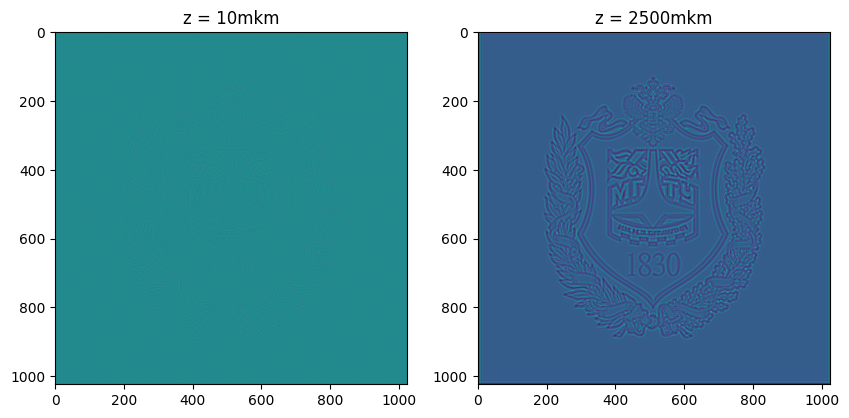

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(np.abs(forward_propagated_fields[0])**2)
ax1.set_title('z = 10mkm')
ax2.imshow(np.abs(forward_propagated_fields[-1])**2)
ax2.set_title('z = 2500mkm')

plt.show()

In [57]:
start=0.000010  # 10 mkm
stop=0.002500  # 1000 mkm
step=0.000010  # 10 mkm

distances = np.arange(start, stop + step, step)
retrieved_phases = {}
for dz, i in zip(distances, range(len(distances))):
    ic(dz)
    intensities = [np.abs(field) ** 2 for field in [forward_propagated_fields[i], back_propagated_fields[i]]]

    dz = 2 * dz
    dz = - dz
    threshold = 0.1

    solver = FFTSolver2D(intensities, dz, wavelength, px_size)
    retrieved_phases[-dz] = solver.solve(threshold)

ic| dz: 1e-05
ic| dz: 2e-05
ic| dz: 3.0000000000000004e-05
ic| dz: 4e-05
ic| dz: 5e-05
ic| dz: 6e-05
ic| dz: 7.000000000000001e-05
ic| dz: 8e-05
ic| dz: 9e-05
ic| dz: 0.0001
ic| dz: 0.00011
ic| dz: 0.00012
ic| dz: 0.00013000000000000002
ic| dz: 0.00014000000000000001
ic| dz: 0.00015000000000000001
ic| dz: 0.00016
ic| dz: 0.00017
ic| dz: 0.00018
ic| dz: 0.00019
ic| dz: 0.0002
ic| dz: 0.00021
ic| dz: 0.00022
ic| dz: 0.00023
ic| dz: 0.00024
ic| dz: 0.00025000000000000006
ic| dz: 0.00026000000000000003
ic| dz: 0.00027000000000000006
ic| dz: 0.00028000000000000003
ic| dz: 0.00029000000000000006
ic| dz: 0.00030000000000000003
ic| dz: 0.00031000000000000005
ic| dz: 0.00032
ic| dz: 0.00033000000000000005
ic| dz: 0.0003400000000000001
ic| dz: 0.00035000000000000005
ic| dz: 0.0003600000000000001
ic| dz: 0.00037000000000000005
ic| dz: 0.0003800000000000001
ic| dz: 0.00039000000000000005
ic| dz: 0.0004000000000000001
ic| dz: 0.00041000000000000005
ic| dz: 0.00042000000000000007
ic| dz: 0.000430000

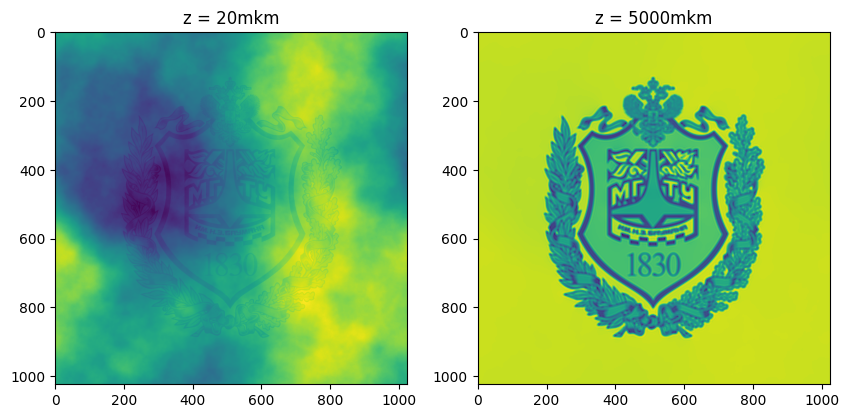

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(retrieved_phases[0.00002])
ax1.set_title('z = 20mkm')
ax2.imshow(retrieved_phases[0.005])
ax2.set_title('z = 5000mkm')

plt.show()

In [78]:
def find_power(data: np.ndarray, threshold:int=0.01) -> int:
    threshold /= 1000
    power = 0
    counter = 0
    for i in data:
        for j in i:
            if (j - counter) ** 2 > threshold: power += j ** 2
            counter = j
        counter = 0
    return power

powers = {}

for dz, phase in retrieved_phases.items():
    ic(dz)
    powers[dz] = find_power(phase)

ic| dz: 2e-05
ic| dz: 4e-05
ic| dz: 6.000000000000001e-05
ic| dz: 8e-05
ic| dz: 0.0001
ic| dz: 0.00012
ic| dz: 0.00014000000000000001
ic| dz: 0.00016
ic| dz: 0.00018
ic| dz: 0.0002
ic| dz: 0.00022
ic| dz: 0.00024
ic| dz: 0.00026000000000000003
ic| dz: 0.00028000000000000003
ic| dz: 0.00030000000000000003
ic| dz: 0.00032
ic| dz: 0.00034
ic| dz: 0.00036
ic| dz: 0.00038
ic| dz: 0.0004
ic| dz: 0.00042
ic| dz: 0.00044
ic| dz: 0.00046
ic| dz: 0.00048
ic| dz: 0.0005000000000000001
ic| dz: 0.0005200000000000001
ic| dz: 0.0005400000000000001
ic| dz: 0.0005600000000000001
ic| dz: 0.0005800000000000001
ic| dz: 0.0006000000000000001
ic| dz: 0.0006200000000000001
ic| dz: 0.00064
ic| dz: 0.0006600000000000001
ic| dz: 0.0006800000000000002
ic| dz: 0.0007000000000000001
ic| dz: 0.0007200000000000002
ic| dz: 0.0007400000000000001
ic| dz: 0.0007600000000000002
ic| dz: 0.0007800000000000001
ic| dz: 0.0008000000000000001
ic| dz: 0.0008200000000000001
ic| dz: 0.0008400000000000001
ic| dz: 0.000860000000000

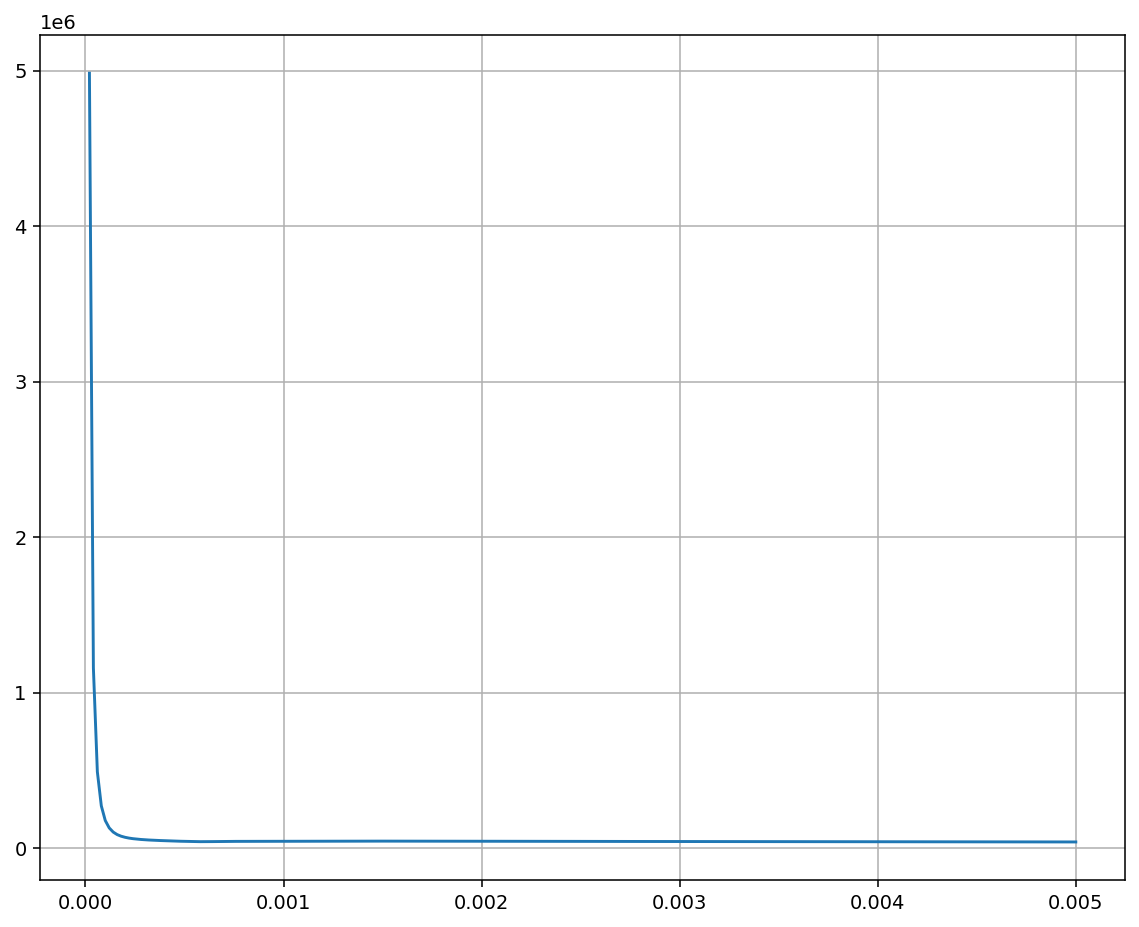

In [79]:
figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()